In [1]:
import volta

In this pipeline we are making use of the network clustering estimated in the Network clustering example pipeline.

The aim is to identify graph structures that are common among clusters or statistically overrepressented in them.

# Load & Preprocess Network

First step of the pipeline consists in loading the chosen data set.
You can store your networks in any common format, however the VOLTA package requires that the networks are provided as NetworkX Graph objects (refer to its documentation for detailed instructions). Moreover, the networks should be weighted: if you have an unweighted network, then assign all edges the same edge weight. The package assumes "weight" to be the default edge weight label, but this can be set when needed.

An example on how to pre-process a network, stored as an edgelist, is provided below. Different loading and storing examples are provided in the "import and export of networks" jupyter notebook. 

In [2]:
#location where the raw data files are stored, it is set to run from the installation folder
#- if applicable please change or CHANGE to the location of your networks

graph_location = "../networks/edgelists/"


In [3]:
#location where output should be saved
#Please set location
location = ""


In [4]:
import glob
import pandas as pd
import networkx as nx
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import os

In [5]:

labels = []
networks_graphs = []
cnt = 0
print("load networks")
#gets all files located in the specified folder that end on .edgelist
#CHANGE the ending if your files end differently
for path in glob.glob(graph_location +"*.edgelist"):
    
        #you can specify that only part of the file name should be used as network name for later identification
        name =  path.split(os.path.sep)[-1].replace(".rds.edgelist", "")

        
        #read the edgelist file as a dataframe
        fh = pd.read_csv(path, sep="\t")
        #convert it into a NetworkX graph G and specify the column names of the node pairs
        G=nx.from_pandas_edgelist(fh, "V1", "V2")

        #if you have an unweighted network assign all edges the same edge weight - here a value of 1 is assigned
        for u, v, d in G.edges(data=True):
            d['weight'] = 1


        #save the graph objects to a list (only suitable if small networks are processed)
        #this is the main objects used for the examples below, which contains all networks
        networks_graphs.append(G)
        labels.append(name)




        print("loaded", name)
    

load networks
loaded dasatinib_A549
loaded dasatinib_BT20
loaded dasatinib_PC3
loaded dasatinib_HCC515
loaded dasatinib_HEPG2
loaded dasatinib_NPC
loaded dasatinib_MCF7
loaded dasatinib_HUVEC
loaded dasatinib_HS578T
loaded dasatinib_SKL
loaded dasatinib_NEU
loaded dasatinib_HT29
loaded dasatinib_SKBR3
loaded dasatinib_HA1E
loaded dasatinib_CD34
loaded dasatinib_HME1
loaded dasatinib_A375
loaded dasatinib_ASC
loaded dasatinib_MDAMB231
loaded mitoxantrone_A549
loaded dasatinib_MCF10A


Get the union og nodes.

In [6]:
nodes = []
for net in networks_graphs:
    for node in net.nodes():
        if node not in nodes:
            nodes.append(node)

## Load clustering estimated in Network clustering pipeline


It reads in the dataframe (stored as csv) created in the network clustering pipeline and stored in the last step. If you have not run the clustering pipeline before a pre-clustered file can be loaded instead. For this run the second cell.

In [12]:
#run this to use the output of the clustering pipeline

clustering = pd.read_csv(location+"clustering_networks.csv")

In [7]:
#run this to use a precompile clustering for the example data 
#adjust location if file is not run from installation directory

clustering = pd.read_csv("../networks/output/clustering_networks.csv")

Convert data to a dictionary (a data stracture in python that is more generally known as an associative array) where key is cluster ID and value is list of NetworkX graph objects in that cluster or its adjacency matrix.

In [8]:
clusters_networks = {}
clusters_adjacencymatrices = {}
for cl in list(Counter(clustering["CLUSTER"].to_list()).keys()):
    clusters_networks[cl] = []
    clusters_adjacencymatrices[cl] = []

for cl in list(Counter(clustering["CLUSTER"].to_list()).keys()):
    #get all drug names and their ids in this cluster
    
    t = clustering.loc[clustering["CLUSTER"]==cl]
    
    drugs = t["CHEMICAL"].to_list()
    temp = []
    temp2 = []
    for d in drugs:
        for i in range(len(labels)):
            if labels[i] == d:
                temp.append(networks_graphs[i])
                temp2.append(nx.to_numpy_matrix(networks_graphs[i], nodelist=nodes,  weight='weight'))
    clusters_networks[cl] = temp
    clusters_adjacencymatrices[cl] = temp2

## Estimate common subgraphs 

Here we show an example of how to estimate subgraphs in case not all the edges are present in all the networks. In detail we show how to estimate the edges present in 75% and 50 % of the networks, respectively. For each of them, the common subnetwork is printed. 

In [9]:
#which edges are in 75% of all graphs in a cluster?

common_75 = {}

for cl in clusters_adjacencymatrices.keys():
    common_75[cl] = volta.pattern_matching.get_common_subgraph(clusters_adjacencymatrices[cl], p=0.75)

cluster  0
cluster  1
cluster  2


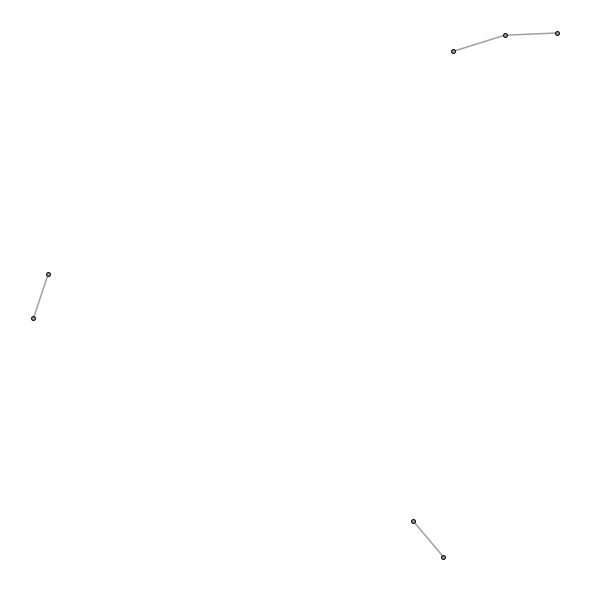

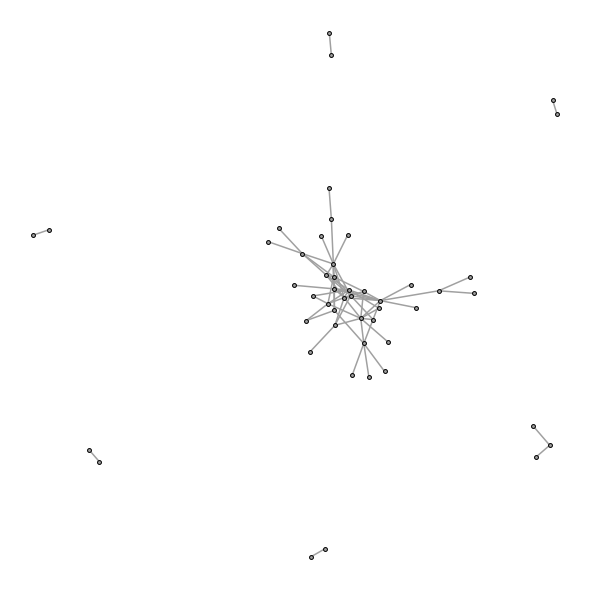

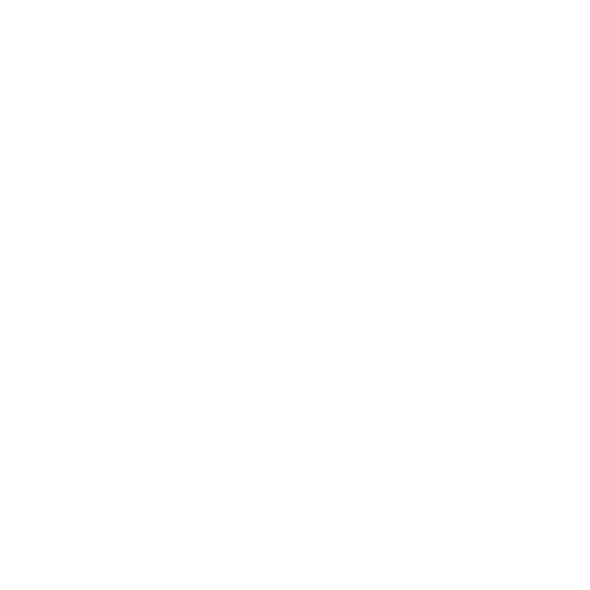

In [10]:
#print the common subnetwork
for i in common_75.keys():
    print("cluster ", i)
    T = volta.pattern_matching.build_graph_remove_isolates(common_75[i])
    
    f, p = volta.plotting.plot_graph(T, pos=None, node_size=15, width=1.5, figsize=(8,8))

In [11]:
#which edges are in 50% of all graphs in a cluster?

common_50 = {}

for cl in clusters_adjacencymatrices.keys():
    common_50[cl] = volta.pattern_matching.get_common_subgraph(clusters_adjacencymatrices[cl], p=0.5)

cluster  0
cluster  1
cluster  2


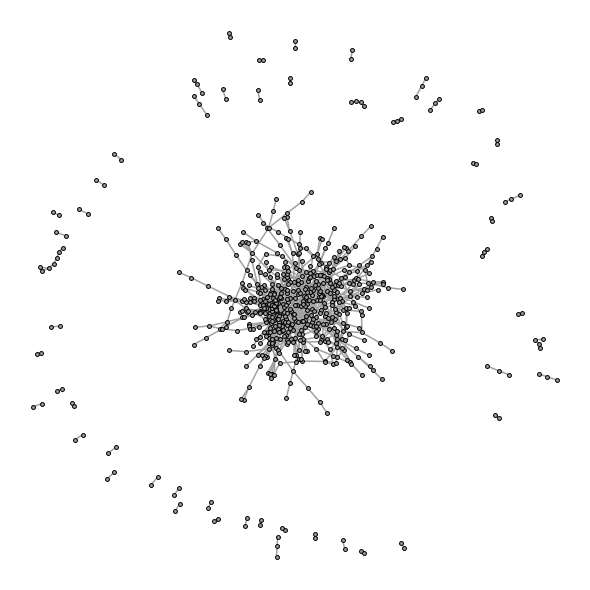

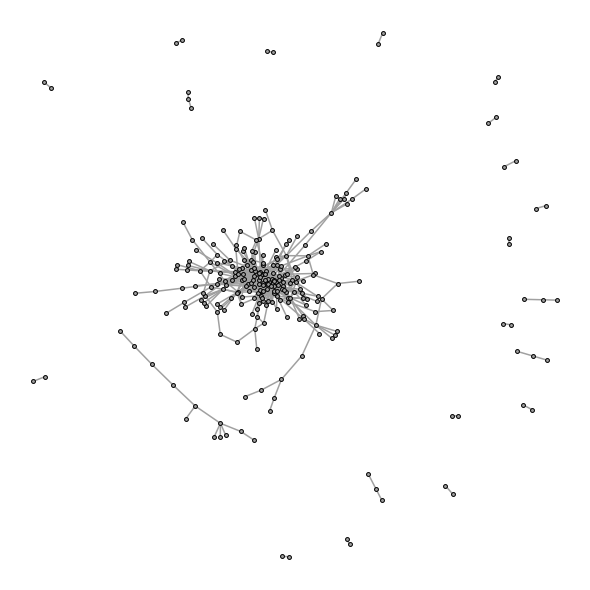

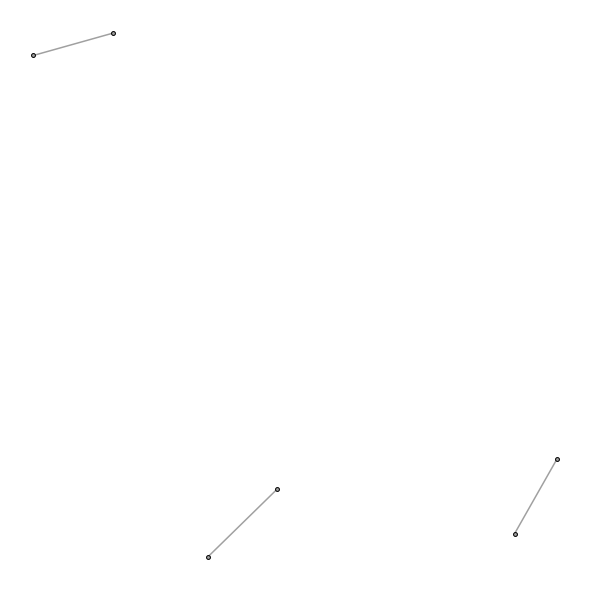

In [12]:
#print the subnetwork
for i in common_50.keys():
    print("cluster ", i)
    T = volta.pattern_matching.build_graph_remove_isolates(common_50[i])
    
    f, p = volta.plotting.plot_graph(T, pos=None, node_size=15, width=1.5, figsize=(8,8))

This method is easy and provides a fast overview if networks withing a cluster share many edges or not, but does not provide any information about the edge distribution within a cluster and between clusters.


Therefore next we are estimating a subgraph based on if a specific edge within a cluster is statistically significant enriched in that cluster. The function estimates p values for each edge within a cluster based on a hypergeometric function and performs correction based on a Benjamin Hochberg correction. Both values are returned.

In [13]:
pval_matrix, adj_pval_matrix = volta.pattern_matching.get_statistical_overrepresented_edges(clusters_adjacencymatrices)

cluster  1
number nodes 544
number edges 572
cluster  2
number nodes 192
number edges 273
cluster  3
number nodes 0
number edges 0


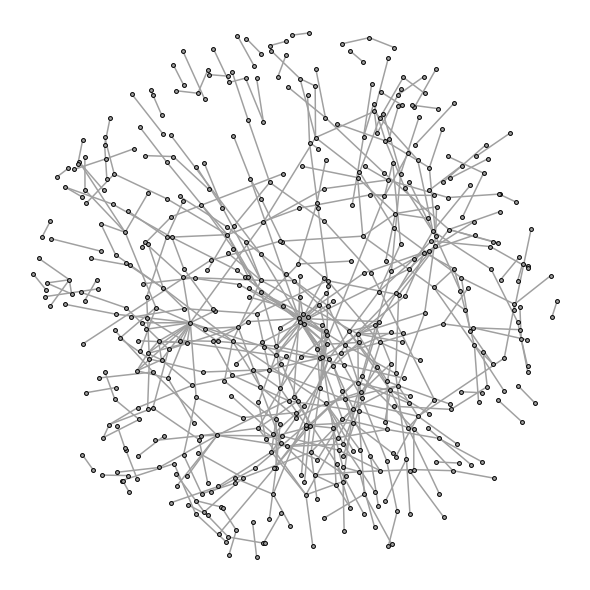

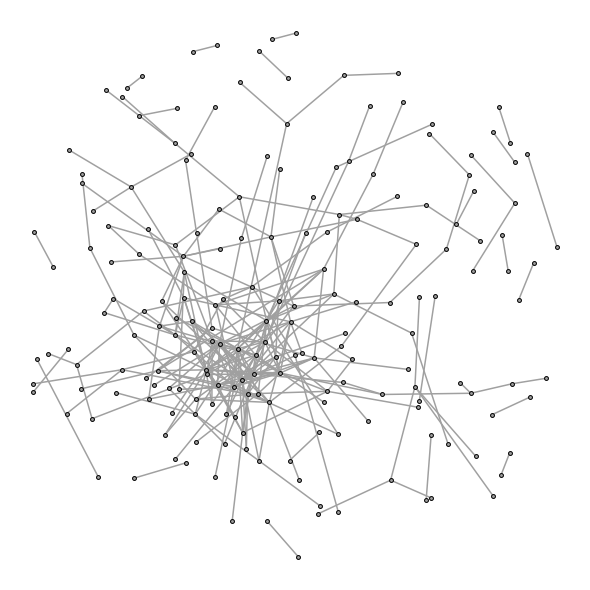

In [14]:
for i in adj_pval_matrix.keys():
    print("cluster ", i)
    
    #set non significant edges to 0
    #Adjust the treshold pval if needed
    A = adj_pval_matrix[i].copy()
    A[A >= 0.05] = 0
    
    
    T = volta.pattern_matching.build_graph_remove_isolates(A)
    print("number nodes", len(T.nodes()))
    print("number edges", len(T.edges()))
    
    if len(T.nodes()) > 0:
        f, p = volta.plotting.plot_graph(T, pos=None, node_size=15, width=1.5, figsize=(8,8))

The estimated subgraphs can be used in replacement for all networks withing a cluster. Nodes & edges can be directly compared as described in the network-network comparison pipeline or modules can be detected and functionally enriched as described in the community detection example file. How to functionally enrich a set of genes is shown in the Examples of Enrichment file.

# Communities

Here, we calculate consensus communities between all graphs within a network group based on each networks individual community structure.
For individual community detection algorithms or ensembl methods, as well as on their application on individual networks, please refer to the community detection example file.

## Consensus Community on a group of networks

For each network, Louvain community detection is performed ten times. By evaluating the different partitionings results for all networks in a group, a consensus is estimated based on clustering.consensus_clustering(), as explained in more detail in the Network clustering pipeline.

In [15]:
consensus = {}

for cl in clusters_networks.keys():
    cons = volta.pattern_matching.get_consensus_community(clusters_networks[cl], nodes,  rep_network=10, threshold=0.75)
    
    consensus[cl] = cons

start removing
removing  216766
rerun
start removing
removing  97212
start removing
removing  336030
rerun
start removing
removing  137494
start removing
removing  305051
rerun
start removing
removing  77995


In [16]:
consensus

{0: array([0, 1, 1, 1, 2, 0, 0, 2, 1, 4, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 1,
        0, 4, 4, 0, 1, 1, 0, 0, 3, 0, 0, 3, 2, 1, 0, 1, 1, 3, 1, 4, 0, 2,
        3, 0, 1, 4, 4, 0, 0, 0, 4, 2, 3, 0, 0, 4, 0, 1, 0, 4, 0, 0, 0, 0,
        1, 4, 1, 2, 2, 2, 1, 2, 1, 2, 2, 4, 4, 0, 4, 2, 0, 2, 2, 3, 2, 0,
        0, 2, 4, 2, 0, 0, 4, 0, 1, 2, 2, 2, 0, 2, 0, 4, 4, 4, 2, 0, 2, 2,
        3, 1, 0, 2, 2, 2, 2, 0, 4, 0, 1, 2, 0, 2, 4, 2, 0, 1, 0, 2, 0, 2,
        0, 4, 1, 1, 3, 1, 2, 2, 0, 4, 1, 3, 0, 4, 0, 1, 2, 4, 4, 3, 3, 1,
        2, 1, 2, 0, 1, 0, 1, 3, 2, 2, 3, 0, 2, 4, 2, 2, 2, 0, 1, 1, 4, 1,
        4, 0, 0, 4, 0, 2, 0, 2, 0, 3, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 4,
        0, 1, 3, 4, 0, 4, 4, 1, 3, 4, 1, 1, 0, 1, 1, 2, 1, 1, 4, 3, 1, 3,
        1, 4, 0, 1, 0, 1, 3, 1, 4, 1, 3, 4, 4, 3, 3, 3, 4, 2, 1, 1, 2, 3,
        2, 3, 4, 2, 2, 2, 0, 4, 2, 0, 3, 0, 0, 2, 3, 0, 4, 4, 0, 1, 1, 4,
        3, 1, 1, 0, 4, 2, 0, 0, 1, 1, 0, 1, 4, 1, 2, 3, 1, 1, 2, 1, 2, 0,
        3, 2, 4, 2, 2, 1, 2, 4, 4, 

For example the communities can be functionally enriched (this is shown in the Example of Enrichment jupyter notebook) and compared between the clusters.
    

Plot the correlation between the three graph partitionings.

In [17]:
all_consensus = [consensus[0], consensus[1], consensus[2]]

In [18]:
group_labels = ["cluster 1", "cluster 2", "cluster 3"]

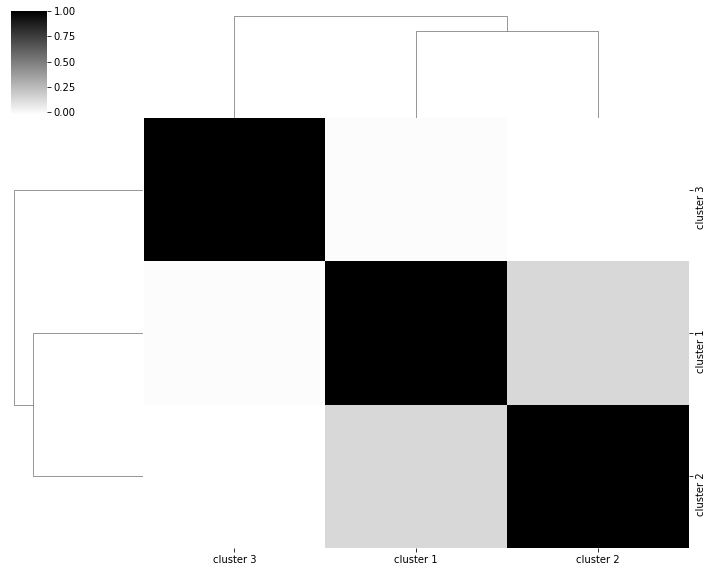

In [19]:
f, c = volta.plotting.plot_correlation_clusterings(all_consensus, xlabels=group_labels, ylabels=group_labels, size=(10,8), cmap="binary")